# W207 Group Project: True vs Fake News 
#### Members: Akiko Iwamizu, Allison Fox, Jason Yang, Rohin Chabra

In [1]:
# Load libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import time
import re
import string
import nltk
import unicodedata

from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D

## Import Data 

In [2]:
# Read in fake news data file.
fake_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/Fake.csv.zip") 
fake = pd.read_csv(fake_zip.open("Fake.csv"))
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Read in true news data file.
true_zip = zipfile.ZipFile("input/fake-and-real-news-dataset/True.csv.zip") 
true = pd.read_csv(true_zip.open("True.csv"))
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
# Create label columns for the fake news data set.
fake["label"] = "false"
fake["label_bin"] = 0
fake.shape

(23481, 6)

In [5]:
# Print the count of fake records by subject. 
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [6]:
# Create label columns for the true news data set.
true["label"] = "true"
true["label_bin"] = 1
true.shape

(21417, 6)

In [7]:
# Print the count of true records by subject.
true['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [8]:
# Merge + combine data sets into one.
data = [fake, true]
df = pd.concat(data, ignore_index=True)
df.shape

(44898, 6)

## Clean & Process Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   label      44898 non-null  object
 5   label_bin  44898 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [10]:
# Confirm the population of each column.
print(f"Null records:\n{df.isna().sum()}\n")
print(f"Empty text records: {len(df[df['text'] == ' '])}\n")
print(f"Empty title records: {len(df[df['title'] == ''])}")

Null records:
title        0
text         0
subject      0
date         0
label        0
label_bin    0
dtype: int64

Empty text records: 627

Empty title records: 0


In [11]:
# Find & remove records where the cleaned text or title column values are empty or NULL.
print(f"Number of text records with a URL: {df['text'].str.count('http|www').sum()}")
print(f"Number of title records with a URL: {df['title'].str.count('http|www').sum()}")
print(f"Number of date records with a URL: {df['date'].str.count('http|www').sum()}")

Number of text records with a URL: 5492
Number of title records with a URL: 9
Number of date records with a URL: 9


In [12]:
# Find records where date column values are invalid.
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
print(f"Number of invalid date records: {len(df.loc[df['date'].isnull()])}")
df.loc[df['date'].isnull()].head(20)

Number of invalid date records: 10


,title,text,subject,date,label,label_bin
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,NaT,false,0
15507,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,NaT,false,0
15508,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,NaT,false,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,NaT,false,0
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,NaT,false,0
18933,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,NaT,false,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0
21870,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,NaT,false,0


In [13]:
# Remove records where date column values are invalid.
df = df.dropna(subset=["date"])
df.shape

(44888, 6)

In [14]:
# Explore the date column.
df["date"].describe()

count          44888
unique          1010
top       2017-12-20
freq             197
Name: date, dtype: object

In [15]:
# Combine the title and text columns into one column.
df['titletext'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,label,label_bin,titletext
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,false,0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,false,0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,false,0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,false,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,false,0,Pope Francis Just Called Out Donald Trump Dur...


In [16]:
# Create a column for publication information. 
# we can split after the first "-" to separate the publication information from the actual text (in the text variable)
# for index, row in df.iterrows():
#     publisher = row['text'].split(" -", maxsplit = 1)
#     row['publisher'] = publisher[0]
# df.head()

In [17]:
# Function for cleaning text inputs.
def preprocess_text(text):
    """Use regex and other tools for pre-processing of the text."""
    # Apply lowercasing.
    text = text.lower()
    
    # Replace stop words with empty strings.
    pattern = re.compile(r"\b(" + r"|".join(stopwords.words('english')) + r')\b\s*')
    text = pattern.sub("", text)
    
    # Replace punctuation with empty strings.
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    
    # Replace all non-alphanumeric characters with a single space.
    text = re.sub(r"[^a-z0-9]+", " ", text)
    
    # Replace large, consecutive amounts of whitespace with a single space.
    text = re.sub(r"[\s]+", " ", text)
    
    # Remove leading and trailing whitespace.
    text = text.strip()
    
    return text

In [18]:
# Clean up text features.
nltk.download("stopwords")

start_time = time.time()
stop_words = set(stopwords.words("english"))

df["clean_title"] = df["title"].apply(lambda text: preprocess_text(text))
df["clean_text"] = df["text"].apply(lambda text: preprocess_text(text))

print(f"{(time.time() - start_time):0.3f} seconds to execute pre-processing text inputs...")

[nltk_data] Downloading package stopwords to C:\Users\Allison
[nltk_data]     Fox\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


47.250 seconds to execute pre-processing text inputs...


In [19]:
# Remove single character words.
pd.options.display.max_colwidth = 500
def singlecharacter(text):
    final_text = []
    words = text.split()
    for i in words:
        if len(i) > 1:
            final_text.append(i)
    return " ".join(final_text)

df['clean_text'] = df['clean_text'].apply(singlecharacter)

In [20]:
df.head()

,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be ...",News,2017-12-31,false,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Med...",donald trump sends embarrassing new year eve message disturbing,donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year 2018 great year america do...
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar whe...",News,2017-12-31,false,0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former ...",drunk bragging trump staffer started russian collusion investigation,house intelligence committee chairman devin nunes going bad day assumption like many us christopher steeledossier prompted russia investigation lashing department justice fbi order protect trump happens dossier started investigation according documents obtained new york timesformer trump campaign adviser george papadopoulos drunk wine bar revealed knowledge russian opposition research hillary clintontop papadopoulos covfefe boy trump administration alleged much larger role none damning drunk...
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been exec..."

In [21]:
df["clean_text"].describe()

count     44888
unique    38362
top            
freq        632
Name: clean_text, dtype: object

In [22]:
df["clean_title"].describe()

count                                           44888
unique                                          38709
top       factbox trump fills top jobs administration
freq                                               14
Name: clean_title, dtype: object

In [23]:
print(f"Empty clean text records: {len(df[df['clean_text'] == ''])}")
df[df["clean_text"] == ""].head()

Empty clean text records: 632


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text
10923,TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?,,politics,2017-05-10,false,0,TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?,take poll think president trump pick replace james comey,
11041,Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO],,politics,2017-04-26,false,0,Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO],joe scarborough berates mika brzezinski cheap shot ivanka trump snotty video,
11190,WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video],,politics,2017-04-06,false,0,WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video],watch tucker carlson scorch sanctuary city mayor believe laws video,
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make Us “Fugitive Slave Catchers” [Video],,politics,2017-04-02,false,0,MAYOR OF SANCTUARY CITY: Trump Trying To Make Us “Fugitive Slave Catchers” [Video],mayor sanctuary city trump trying make us fugitive slave catchers video,
11236,SHOCKER: Public School Turns Computer Lab Into Mosque…Bars Non-Muslim Students [Video],,politics,2017-04-01,false,0,SHOCKER: Public School Turns Computer Lab Into Mosque…Bars Non-Muslim Students [Video],shocker public school turns computer lab mosque bars nonmuslim students video,


In [24]:
print(f"Empty clean title records: {len(df[df['clean_title'] == ''])}")
df[df["clean_title"] == ""].head()

Empty clean title records: 0


,title,text,subject,date,label,label_bin,titletext,clean_title,clean_text


There are 36959950 words across all the articles.


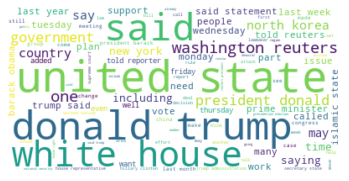

In [37]:
# Create a word cloud of all the true records.
truefilt = df[(df['label_bin'] == 1)]
text = " ".join(article for article in truefilt.clean_text)

# print the number of words across all the articles
print ("There are {} words across all the articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 40978650 words across all the articles.


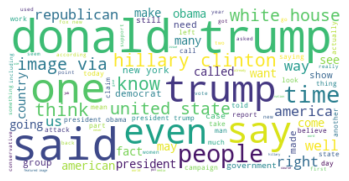

In [38]:
# Create a word cloud of all the fake records.
fakefilt = df[(df['label_bin'] == 0)]
text = " ".join(article for article in fakefilt.clean_text)

# print the number of words across all the articles
print ("There are {} words across all the articles.".format(len(text)))

# Create and generate a word cloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### QUESTION: Should we remove records without text?

## Split Train, Test, & Dev Data

In [27]:
# Split data sets into train (70%), test (15%), & dev (15%).
# Use random_state param to reproduce shuffle outcomes.
train, test = train_test_split(df, random_state=0, train_size=0.7, test_size=0.3, shuffle=True)
num_test = int(len(test)/2)
test = test[num_test:]
dev = test[:num_test]

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("Dev data shape:", dev.shape)

Train data shape: (31421, 9)
Test data shape: (6734, 9)
Dev data shape: (6733, 9)


In [28]:
# Export train, test, & dev data sets to dir.
# Write a Pandas DataFrame as a zipped CSV file.
#train.to_csv("input/processed-datasets/train.csv", index=False)
#test.to_csv("input/processed-datasets/test.csv", index=False)
#dev.to_csv("input/processed-datasets/dev.csv", index=False)

## Exploratory Data Analysis

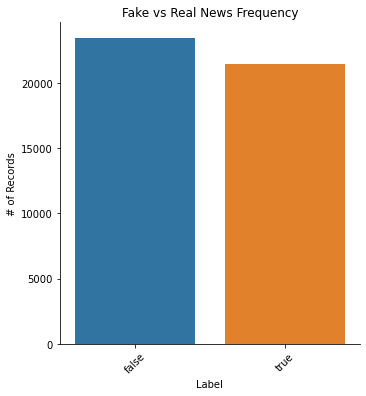

In [29]:
# Histograms looking at the distribution of fake vs real news labels.
g = sns.catplot(data=df, x="label", kind="count")
g.set(xlabel="Label", ylabel="# of Records", title="Fake vs Real News Frequency")
g.set_xticklabels(rotation=45)

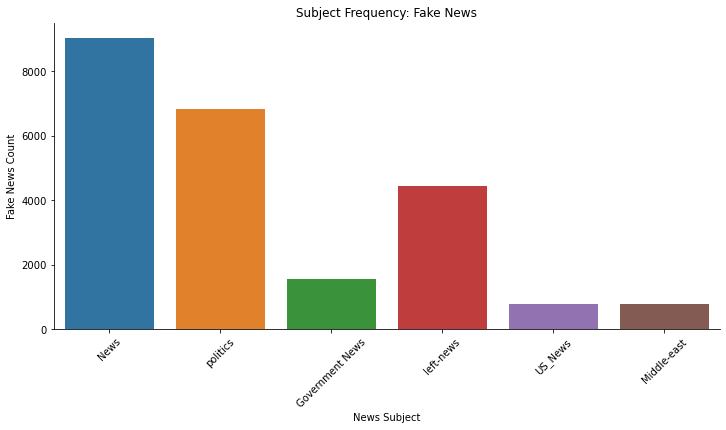

In [30]:
# Histogram looking at the frequency of fake news subjects.
g = sns.catplot(data=fake, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="Fake News Count", title="Subject Frequency: Fake News")
g.set_xticklabels(rotation=45)

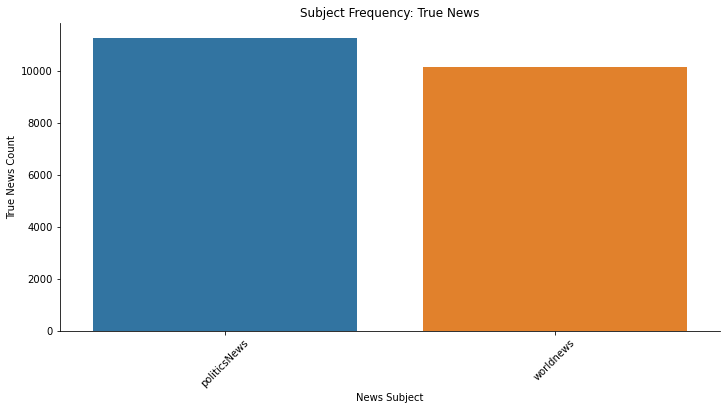

In [31]:
# Histogram looking at the frequency of true news subjects.
g = sns.catplot(data=true, x="subject", col="label_bin", kind="count", aspect=2)
g.set(xlabel="News Subject", ylabel="True News Count", title="Subject Frequency: True News")
g.set_xticklabels(rotation=45)

### QUESTION: Should we be concerned that there is no overlap in subjects between fake vs true news?

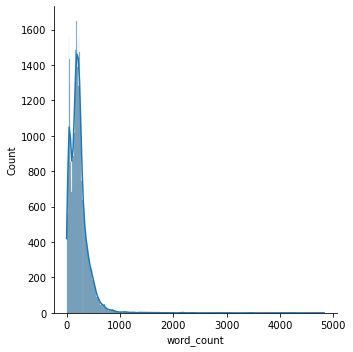

In [32]:
# Distribution of the word count of the clean text values of the news data.
df["word_count"] = df["clean_text"].apply(lambda x: len(str(x).split()))
sns.displot(df["word_count"], kde=True)
fig = plt.gcf()

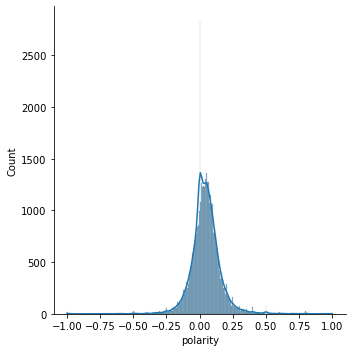

In [33]:
# Distribution of the polarity of the clean text values of the news data. Appears to be neutral on average.
df["polarity"] = df["clean_text"].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(df["polarity"], kde=True)
fig = plt.gcf()

Word count in longest real article: 2392
Word count in longest fake article: 4830


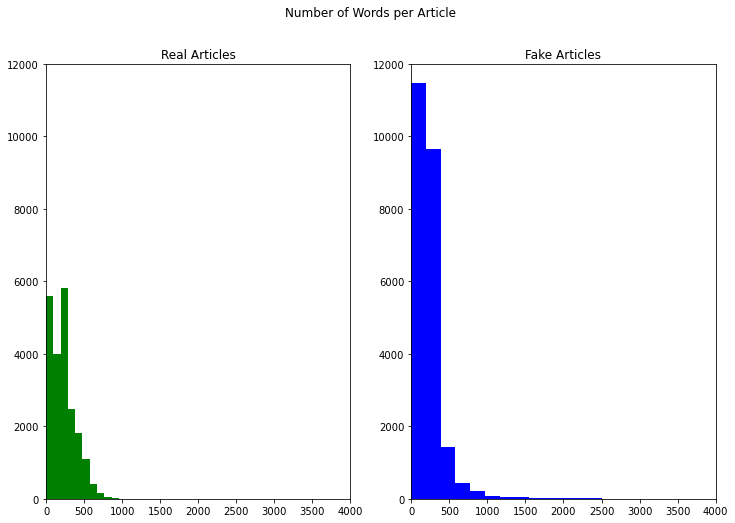

In [34]:
# Histogram of word length in fake news vs. in real news.
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))
ylim = [0, 12000]
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
xlim = [0, 4000]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
text_length = df[df['label_bin'] == 1]['clean_text'].str.split().map(lambda x: len(x))
print("Word count in longest real article:", max(text_length))
ax1.hist(text_length, color='green', bins = 25)
ax1.set_title('Real Articles')
text_length = df[df['label_bin'] == 0]['clean_text'].str.split().map(lambda x: len(x))
print("Word count in longest fake article:", max(text_length))
ax2.hist(text_length, color = 'blue', bins = 25)
ax2.set_title('Fake Articles')
fig.suptitle('Number of Words per Article')
plt.show()

Character count in longest real article: 17958
Character count in longest fake article: 38702


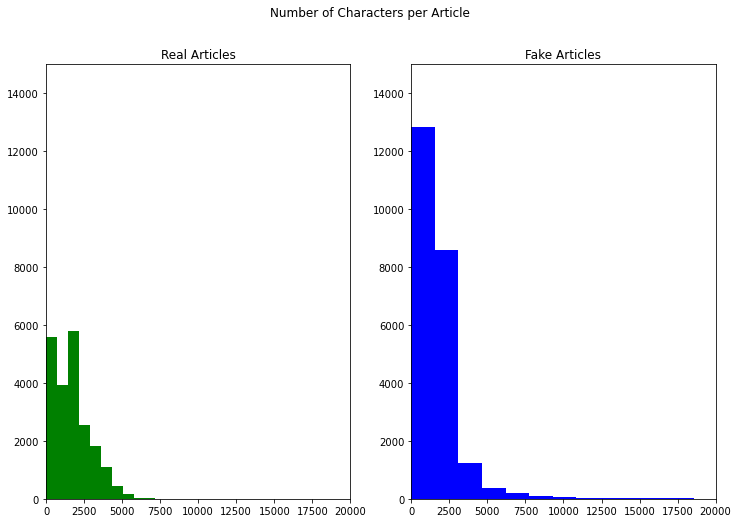

In [36]:
# Histogram of character count in fake news vs. in real news.
fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))
ylim = [0, 15000]
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
xlim = [0, 20000]
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)
text_length = df[df['label_bin'] == 1]['clean_text'].str.len()
print("Character count in longest real article:", max(text_length))
ax1.hist(text_length, color='green', bins = 25)
ax1.set_title('Real Articles')
text_length = df[df['label_bin'] == 0]['clean_text'].str.len()
print("Character count in longest fake article:", max(text_length))
ax2.hist(text_length, color = 'blue', bins = 25)
ax2.set_title('Fake Articles')
fig.suptitle('Number of Characters per Article')
plt.show()